In [6]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.misc as smp
from PIL import Image
import numba
from numba import njit, vectorize, cuda
from timeit import default_timer as timer
from pylab import imshow, show
from tqdm import tqdm

In [7]:
resolution = (1920,1080)
J_c = (-0.743643887037151,0.131825904205330)
J_z = 68227450827.50151


@njit
def Mandelbrot(x, y, max_iterations):
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iterations):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >=4:
            return i
    
    return max_iterations

mandel_gpu = cuda.jit(device=True)(Mandelbrot)

@cuda.jit
def render_kernel(centre_x, centre_y, zoom, max_iter, rendergrid):
    xmin = centre_x - (3.5/(2*zoom))
    xmax = centre_x + (3.5/(2*zoom))
    ymin = centre_y - (2/(2*zoom))
    ymax = centre_y + (2/(2*zoom))

    pixel_width = (xmax-xmin)/resolution[0]
    pixel_height = (ymax-ymin)/resolution[1]
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y

    for i in range(startX, resolution[0], gridX):
        real = xmin + i*pixel_width
        for j in range(startY, resolution[1], gridY):
            imaginary = ymin + j*pixel_height
            colour = mandel_gpu(real,imaginary, max_iter)
            rendergrid[j,i] = colour

Mandelbrot created on GPU in 1.188267 s


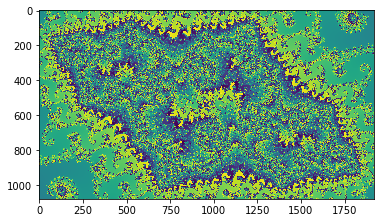

In [13]:
grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
blockdim = (32,8)
griddim = (32,16)

start = timer()
d_rendergrid = cuda.to_device(grendergrid)
render_kernel[griddim, blockdim](J_c[0], J_c[1], J_z, 10000, d_rendergrid) 
d_rendergrid.to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)

imshow(grendergrid)
show()

In [11]:
frames = []
for i in tqdm(range(300)):
    grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
    blockdim = (32,32)
    griddim = (32,32)
    d_rendergrid = cuda.to_device(grendergrid)
    render_kernel[griddim, blockdim](J_c[0], J_c[1], 2**(i/6), 10000, d_rendergrid) 
    d_rendergrid.to_host()
    img = Image.fromarray( grendergrid )       # Create a PIL image
    frames.append(img)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [25:51<00:00,  5.17s/it]


In [15]:
frames[0].save('Greyscale_Zoom.gif', format='GIF', append_images=frames[1:], save_all=True, duration=175, loop=0, quality=20, optimize=True)